# Demo - Adversarial Training with MNIST

In [1]:
import os
import sys
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Load MNIST Data

In [3]:
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [4]:
batch_size = 128

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                         batch_size=batch_size,
                                         shuffle=False)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

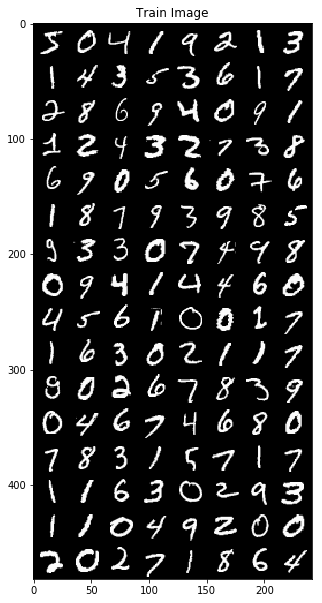

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## 2. Define Model

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,5),
            nn.ReLU(),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*3*3,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )       
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(-1,64*3*3)
        out = self.fc_layer(out)

        return out

In [8]:
model = CNN().cuda()

In [9]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
pgd_attack = torchattacks.PGD(model, eps=0.3, alpha=2/255, iters=10)

## 3. Train Model

In [11]:
num_epochs = 5

In [12]:
for epoch in range(num_epochs):

    total_batch = len(mnist_train) // batch_size

    for i, (batch_images, batch_labels) in enumerate(train_loader):

        # Normal Trianing
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        # Adversarial Training
        pgd_attack.update_model(model)
        X = pgd_attack(batch_images, batch_labels).cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/5], lter [100/468], Loss: 0.4142
Epoch [1/5], lter [200/468], Loss: 0.2272
Epoch [1/5], lter [300/468], Loss: 0.3132
Epoch [1/5], lter [400/468], Loss: 0.1287
Epoch [2/5], lter [100/468], Loss: 0.0839
Epoch [2/5], lter [200/468], Loss: 0.1477
Epoch [2/5], lter [300/468], Loss: 0.1679
Epoch [2/5], lter [400/468], Loss: 0.0427
Epoch [3/5], lter [100/468], Loss: 0.0543
Epoch [3/5], lter [200/468], Loss: 0.1217
Epoch [3/5], lter [300/468], Loss: 0.1259
Epoch [3/5], lter [400/468], Loss: 0.0226
Epoch [4/5], lter [100/468], Loss: 0.0463
Epoch [4/5], lter [200/468], Loss: 0.1085
Epoch [4/5], lter [300/468], Loss: 0.0977
Epoch [4/5], lter [400/468], Loss: 0.0165
Epoch [5/5], lter [100/468], Loss: 0.0383
Epoch [5/5], lter [200/468], Loss: 0.0939
Epoch [5/5], lter [300/468], Loss: 0.0903
Epoch [5/5], lter [400/468], Loss: 0.0124


## 4. Test Model

### 4.1 Normal Data

In [13]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of normal images: %f %%' % (100 * float(correct) / total))

Accuracy of normal images: 99.210000 %


### 4.2 Attack with FGSM

In [14]:
model.eval()

correct = 0
total = 0

fgsm_attack = torchattacks.FGSM(model)

for images, labels in test_loader:
    
    images = fgsm_attack(images, labels).cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of adversarial images: %f %%' % (100 * float(correct) / total))

Accuracy of adversarial images: 99.100000 %
